In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

Data Pre-processing

In [2]:
# import dataset from csv file
import pandas as pd
with open('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'r') as f:
    data = pd.read_csv(f)
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             225745 non-null  int64  
 1    Flow Duration                225745 non-null  int64  
 2    Total Fwd Packets            225745 non-null  int64  
 3    Total Backward Packets       225745 non-null  int64  
 4   Total Length of Fwd Packets   225745 non-null  int64  
 5    Total Length of Bwd Packets  225745 non-null  int64  
 6    Fwd Packet Length Max        225745 non-null  int64  
 7    Fwd Packet Length Min        225745 non-null  int64  
 8    Fwd Packet Length Mean       225745 non-null  float64
 9    Fwd Packet Length Std        225745 non-null  float64
 10  Bwd Packet Length Max         225745 non-null  int64  
 11   Bwd Packet Length Min        225745 non-null  int64  
 12   Bwd Packet Length Mean       225745 non-nul

In [4]:
data.isnull().sum()  # check for missing values

 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64

In [5]:
data.isna().sum()  # check for missing values

 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64

In [6]:
# strip column names of any leading or trailing spaces
data.columns = data.columns.str.strip()

# separate features and labels
X = data.drop(columns=['Label'])
y = data['Label']

# map BENIGN to 0 and DoS to 1
y = y.map({'BENIGN': 0, 'DDoS': 1})

print(X.shape, y.shape)

(225745, 78) (225745,)


In [7]:
# Replace infinite values with NaN and then fill them with the column mean
X.replace([np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Convert time series into sequences for LSTM
def create_sequences(data, labels, timesteps=10):
    X_seq, y_seq = [], []
    for i in range(len(data) - timesteps):
        X_seq.append(data[i: i + timesteps])
        y_seq.append(labels[i + timesteps])  # Label for last timestep
    return np.array(X_seq), np.array(y_seq)

timesteps = 20
X_seq, y_seq = create_sequences(X_scaled, y, timesteps)

print(X_seq.shape, y_seq.shape)

(225725, 20, 78) (225725,)


In [9]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

# Train-test split
train_size = int(0.7 * len(X_tensor))
val_size = int(0.15 * len(X_tensor))
test_size = len(X_tensor) - train_size - val_size
X_train, X_val, X_test = torch.split(X_tensor, [train_size, val_size, test_size])
y_train, y_val, y_test = torch.split(y_tensor, [train_size, val_size, test_size])

# Create PyTorch Dataset & DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model

In [10]:
import torch.nn as nn
import torch.optim as optim

# Define LSTM Model for Classification
class LSTMAnomalyDetector(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=1):
        super(LSTMAnomalyDetector, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Binary classification (normal vs anomaly)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take last LSTM output
        return self.sigmoid(out)

# Move model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMAnomalyDetector(input_size=78, hidden_size=128).to(device)
print("Model architecture:", model)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

Model architecture: LSTMAnomalyDetector(
  (lstm): LSTM(78, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [11]:
# Training loop
epochs = 20

for epoch in range(epochs):
    # Training step
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Validateion step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    # Print epoch results
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1/20, Train Loss: 0.0057, Val Loss: 0.0022
Epoch 2/20, Train Loss: 0.0016, Val Loss: 0.0012
Epoch 3/20, Train Loss: 0.0014, Val Loss: 0.0012
Epoch 4/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 5/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 6/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 10/20, Train Loss: 0.0010, Val Loss: 0.0020
Epoch 11/20, Train Loss: 0.0010, Val Loss: 0.0018
Epoch 12/20, Train Loss: 0.0009, Val Loss: 0.0020
Epoch 13/20, Train Loss: 0.0009, Val Loss: 0.0016
Epoch 14/20, Train Loss: 0.0009, Val Loss: 0.0021
Epoch 15/20, Train Loss: 0.0009, Val Loss: 0.0017
Epoch 16/20, Train Loss: 0.0008, Val Loss: 0.0020
Epoch 17/20, Train Loss: 0.0007, Val Loss: 0.0021
Epoch 18/20, Train Loss: 0.0007, Val Loss: 0.0020
Epoch 19/20, Train Loss: 0.0006, Val Loss: 0.0037
Epoch 20/20, Train Loss: 0.0007, Val Loss: 0.0040


In [12]:
# Testing the model
model.eval()
y_preds = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).squeeze().cpu().numpy()
        y_preds.extend(outputs)
        y_true.extend(y_batch.numpy())

# Convert predictions to binary (0 or 1)
y_preds = np.array(y_preds)
y_preds = (y_preds > 0.5).astype(int)

# Compute Accuracy
accuracy = np.mean(y_preds == y_true)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9984


In [13]:
# Compute precision, recall, and F1-score
from sklearn.metrics import classification_report
print(classification_report(y_true, y_preds, target_names=['BENGIN', 'DDos']))

              precision    recall  f1-score   support

      BENGIN       1.00      1.00      1.00     30951
        DDos       0.99      0.99      0.99      2909

    accuracy                           1.00     33860
   macro avg       0.99      1.00      0.99     33860
weighted avg       1.00      1.00      1.00     33860



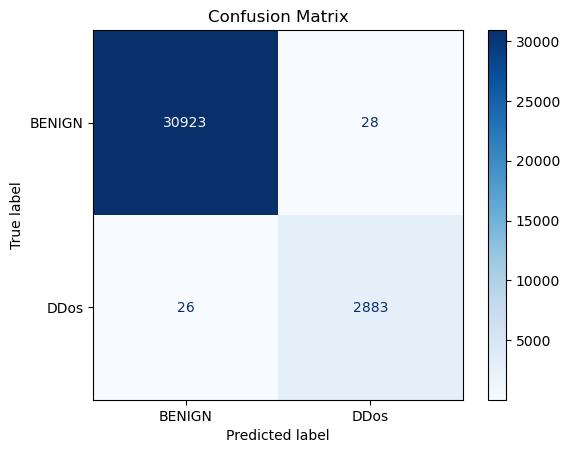

In [14]:
# draw confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['BENIGN', 'DDos'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

ROC AUC: 0.9951


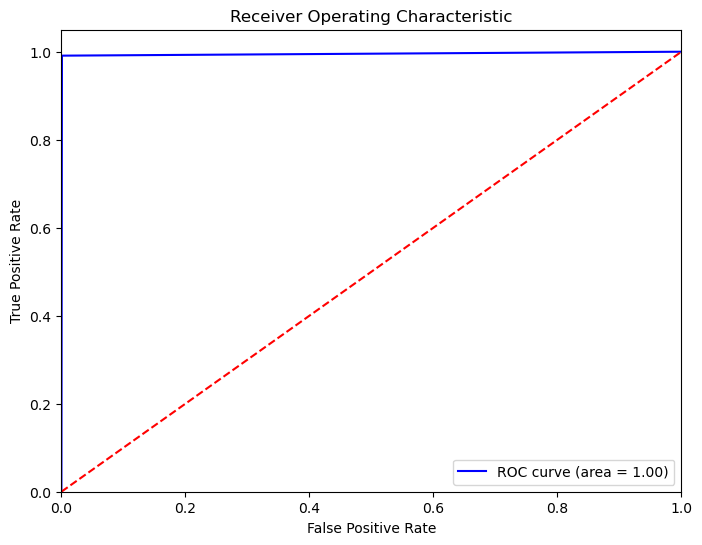

In [15]:
# draw ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_preds)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right') 
plt.show()